In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Path to dataset files: /kaggle/input/chest-xray-pneumonia


In [ ]:
import os
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torchvision.models import resnet50, ResNet50_Weights
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
class PneumoniaDataset(Dataset):
  def __init__(self, root_dir, transform=None):
    self.root_dir = root_dir
    self.transform = transform
    self.image_paths = []
    self.labels = []

    for class_name in os.listdir(root_dir):
      class_dir = os.path.join(root_dir, class_name)
      for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
        self.image_paths.append(image_path)
        self.labels.append(0 if (class_name == "NORMAL") else 1)

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, idx):
    image = Image.open(self.image_paths[idx]).convert("RGB")
    if self.transform:
      image = self.transform(image)

    label = self.labels[idx]

    return image, label

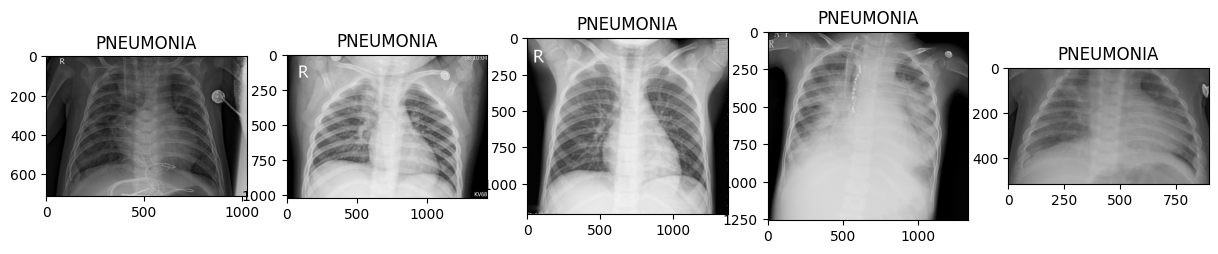

In [ ]:
# DISPLAYING SOME IMAGE IN THE DATASET

display_dataset = PneumoniaDataset(root_dir="/kaggle/input/chest-xray-pneumonia/chest_xray/train")

image_display = [display_dataset[i][0] for i in range(5)]
label_display = [display_dataset[i][1] for i in range(5)]

fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
  axes[i].imshow(image_display[i])
  axes[i].set_title("NORMAL" if (label_display[i] == 0) else "PNEUMONIA")

# print(image_display[0])
# print(label_display[0])



In [ ]:
train_transfrom = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5), # 50% of images are flipped
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = PneumoniaDataset(root_dir="/kaggle/input/chest-xray-pneumonia/chest_xray/train", transform=train_transfrom)
test_dataset = PneumoniaDataset(root_dir="/kaggle/input/chest-xray-pneumonia/chest_xray/test", transform=val_test_transforms)
val_dataset = PneumoniaDataset(root_dir="/kaggle/input/chest-xray-pneumonia/chest_xray/val", transform=val_test_transforms)

print("Train's length:", len(train_dataset))
print("Test's length:", len(test_dataset))
print("Val's length:", len(val_dataset))

Train's length: 5216
Test's length: 624
Val's length: 16


In [ ]:
# Here, we take test_dataset as validation dataset in the training process, and the val_dataset will
# be used to evaluate the final model, because the size of the test_dataset is bigger, reflect better
# the accuracy of the model, if the size is too small, it could lead to 1.0 acc or 0.0 acc because
# one prediction matters a lot in the smal size.

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


In [ ]:
def train_model(num_epochs, model, train_loader, val_loader, criterion, optimizer, device):
  # !!! MAKE SURE THE MODEL IS IN THE GIVEN DEVICE

  best_acc = 0

  train_figure = {
      "train_loss": [],
      "val_loss": [],
      "val_acc": [],
  }

  for epoch in range(num_epochs):

    total_train_loss = 0
    total_val_loss = 0

    # Training
    model.train()
    for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)

      optimizer.zero_grad()

      outputs = model(images)
      loss = criterion(outputs, labels)

      loss.backward()
      optimizer.step()

      total_train_loss += loss.item()

    train_loss = total_train_loss / len(train_loader)
    train_figure["train_loss"].append(train_loss)
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"train_loss: {train_loss:.4f}")

    # Evaluating
    val_preds = []
    val_labels = []
    model.eval()
    with torch.no_grad():
      for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)

        val_preds.extend(preds.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

        total_val_loss += loss.item()

      val_loss = total_val_loss / len(val_loader)
      train_figure["val_loss"].append(val_loss)

      val_acc = accuracy_score(val_preds, val_labels)
      train_figure["val_acc"].append(val_acc)

      print(f"val_loss: {val_loss:.4f}, val_accuracy: {val_acc:.4f}")

      if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_resnet50_model.pth")
        print(f"Best model saved at Epoch {epoch+1}: {best_acc:.4f}")

      print("="*70)

  return train_figure

In [ ]:
num_classes = 2
num_epochs = 15

model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

train_figure = train_model(
    num_epochs=num_epochs,
    model=model,
    train_loader=train_loader,
    val_loader=test_loader,
    criterion=nn.CrossEntropyLoss(),
    optimizer=optim.Adam(model.parameters(), lr=1e-4),
    device=device
)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 219MB/s]


Epoch 1/15
train_loss: 0.1618
val_loss: 0.3713, val_accuracy: 0.8590
Best model saved at Epoch 1: 0.8590
Epoch 2/15
train_loss: 0.0787
val_loss: 0.4211, val_accuracy: 0.8446
Epoch 3/15
train_loss: 0.0666
val_loss: 0.4053, val_accuracy: 0.8574
Epoch 4/15
train_loss: 0.0468
val_loss: 0.4462, val_accuracy: 0.8766
Best model saved at Epoch 4: 0.8766
Epoch 5/15
train_loss: 0.0453
val_loss: 0.7561, val_accuracy: 0.8189
Epoch 6/15
train_loss: 0.0437
val_loss: 0.4897, val_accuracy: 0.8622
Epoch 7/15
train_loss: 0.0257
val_loss: 0.6301, val_accuracy: 0.8622
Epoch 8/15
train_loss: 0.0336
val_loss: 0.2803, val_accuracy: 0.9279
Best model saved at Epoch 8: 0.9279
Epoch 9/15
train_loss: 0.0231
val_loss: 0.5358, val_accuracy: 0.8894
Epoch 10/15
train_loss: 0.0253
val_loss: 0.7033, val_accuracy: 0.8702
Epoch 11/15
train_loss: 0.0236
val_loss: 0.4524, val_accuracy: 0.9054
Epoch 12/15
train_loss: 0.0234
val_loss: 0.5705, val_accuracy: 0.8974
Epoch 13/15
train_loss: 0.0168
val_loss: 0.6199, val_accuracy

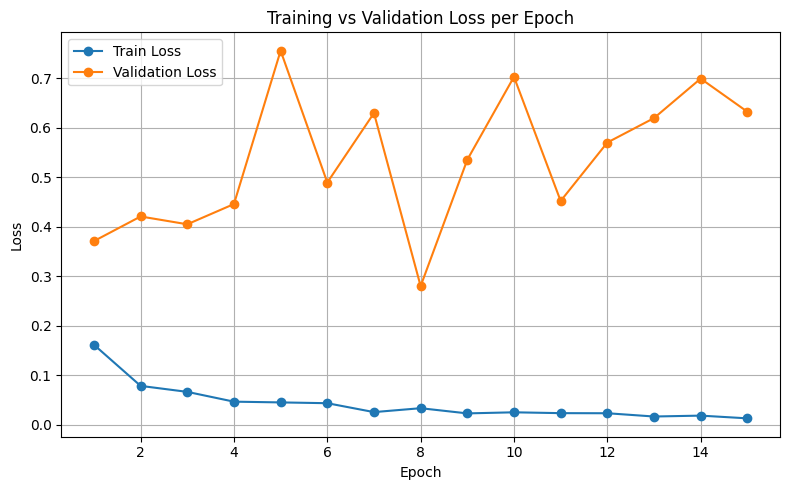

In [ ]:
import matplotlib.pyplot as plt

# Data from training log
epochs = list(range(1, 16))
train_loss = [0.1618, 0.0787, 0.0666, 0.0468, 0.0453, 0.0437, 0.0257, 0.0336, 0.0231, 0.0253, 0.0236, 0.0234, 0.0168, 0.0186, 0.0131]
val_loss = [0.3713, 0.4211, 0.4053, 0.4462, 0.7561, 0.4897, 0.6301, 0.2803, 0.5358, 0.7033, 0.4524, 0.5705, 0.6199, 0.6997, 0.6328]

# Plotting
plt.figure(figsize=(8,5))
plt.plot(epochs, train_loss, marker='o', label='Train Loss')
plt.plot(epochs, val_loss, marker='o', label='Validation Loss')
plt.title('Training vs Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
def evaluate_model(val_loader, model, class_name, matrix=False):

  from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
  model.eval()

  val_preds = []
  val_labels = []
  with torch.no_grad():
    for images, labels in val_loader:
      outputs = model(images)
      _, preds = torch.max(outputs, dim=1)

      val_preds.extend(preds.cpu().numpy())
      val_labels.extend(labels.cpu().numpy())

    if matrix:
      cm = confusion_matrix(val_labels, val_preds)

      disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_name)
      disp.plot(cmap="Blues", xticks_rotation=45)
      plt.title("Confusion Matrix")
      plt.show()


  return accuracy_score(val_preds, val_labels)



In [ ]:
num_classes=2

best_model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
best_model.fc = nn.Linear(best_model.fc.in_features, num_classes)

best_model.load_state_dict(torch.load("/content/best_resnet50_model.pth", map_location=device))

<All keys matched successfully>

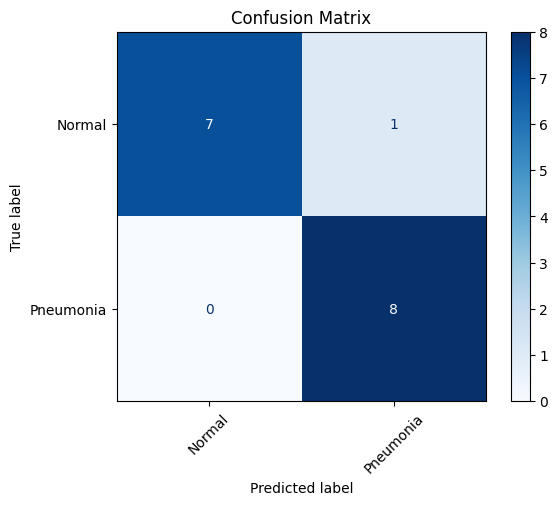

0.9375

In [ ]:
evaluate_model(val_loader, best_model, matrix=True, class_name=["Normal", "Pneumonia"])

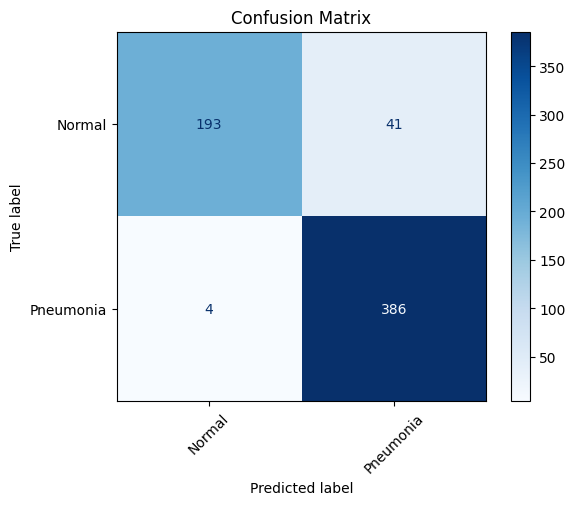

0.9278846153846154

In [ ]:
evaluate_model(test_loader, best_model, matrix=True, class_name=["Normal", "Pneumonia"])